*Andrew Calderwood*

In [1]:
import os
from os.path import basename, dirname, join
import sys

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

from scipy.optimize import minimize

from datetime import datetime
from datetime import timedelta
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# from pandas.tseries import converter

In [2]:

## Set up directory referencing
# Package data
git_dir = os.getcwd()
while basename(git_dir) != 'CosumnesRiverRecharge':
    git_dir = dirname(git_dir)
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir = join(usr_dir, temp)
gwfm_dir = join(usr_dir, 'Box/research_cosumnes/GWFlowModel')
# print(git_dir, gwfm_dir)
gwfm_dir

'C:\\Users\\ajcalder\\Box/research_cosumnes/GWFlowModel'

In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'
tprogs_id = '_no_cond_c3d'


data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [4]:
fxn_dir = git_dir+'/python_utilities'
if fxn_dir not in sys.path:
    sys.path.append(fxn_dir)
# sys.path
# import muskingum_recharge as mr

from importlib import reload
# reload(mr)

In [5]:
nrow = 100
ncol = 230
rows = np.repeat(np.arange(0,nrow),ncol)
cols = np.tile(np.arange(0,ncol),nrow)

# dem data for cropping above land surface
# dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_linear.tsv')
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

zs = gpd.read_file(gwfm_dir+'/DIS_data/grid_elevation_m_statistics.shp')
# columns with different quantiles 0 to 100% of elevation
q_cols = zs.columns[zs.columns.str.contains('perc')]
df_elevs = zs[q_cols]

# convert quantile dataframe to a 3D array
arr_elev = np.zeros((df_elevs.shape[1], zs.row.max(),zs.column.max()))
for n in np.arange(0,df_elevs.shape[1]):
    arr_elev[n, zs.row-1, zs.column-1] = df_elevs.iloc[:,n]

# No flow routing, recharge loss only

In [8]:
Q_cfs = 22500 # 5 year
# Q_cfs = 2000 # 1ish year

Q_cms = Q_cfs*(0.3048**3) # convert to cubic meters per second


In [9]:
import muskingum_recharge
reload(muskingum_recharge)

from muskingum_recharge import min_Q, mannings, calc_depth_arr, xs_setback


In [10]:
setbacks = np.arange(0, 3400,200)
# smoothed XS data used for setback analysis
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv', index_col='dist_from_right_m')
num_segs = xs_levee_smooth.shape[1]
# wse_grid.to_file(gis_dir+'wse_grid.shp')

# load array identifying row,col to setback ID (1,17)
str_setbacks = np.loadtxt(chan_dir+ 'regional_str_setback_id_arr.tsv', delimiter='\t').astype(int)
# str_setbacks = ma.masked_where(str_setbacks==0,str_setbacks)
str_setbacks = np.where(str_setbacks==0,np.NaN, str_setbacks)

# load array identifying row,col to XS id (1,28)
xs_arr = np.loadtxt(chan_dir+'XS_num_grid_reference.tsv')

# load flood typology characteristics (based on daily data 1908 - 2014) - median values 
#"cms_pk" for peak discharge, "pk_loc" for time to peak, and "log_no_d" for duration
flood_type = pd.read_csv(join(box_dir, 'whipple_grp6_w97ftmedians.csv'),index_col='Group.1')


In [11]:
soil_thick=2
fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth.tsv'

# units of m/day
soil_K_out = np.loadtxt(fn, delimiter='\t')
soil_K = np.reshape(soil_K_out, (100, nrow, ncol))
# convert soil conductivity from m/d to m/s and apply vertical anisotropy factor
vani = 100
soil_K = soil_K/86400/vani 

In [12]:
flow_percentile=95
flow_percentile=6

hf_tot_in =  np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(flow_percentile)+'.tsv',delimiter = '\t')
hf_tot = np.reshape(hf_tot_in, (100, nrow, ncol))


In [13]:
# t=0
# plt.imshow(hf_tot[t,:])
# plt.imshow(hf_tot[t,:]*(str_setbacks>0))
# (hf_tot[t,:]*(str_setbacks>0)).sum()*200*200
# plt.show()

# # if we assume that for this layer the proportions are equal as regionally which probably isn't true
# # coarse = soil_K > np.quantile(soil_K[t,:,:], [0.76])
# # assume that the coarse facies should be greater than the arithmetic mean
# coarse = soil_K > np.mean(soil_K[t,:,:], axis=(0,1))
# plt.imshow(coarse[t,:]*(str_setbacks>0))
# plt.show()
# plt.imshow(hf_tot[t,:]*coarse[t,:])
# np.sum(hf_tot[t,:]*coarse[t,:]), np.sum(hf_tot[t,:]), np.sum(coarse[t,:]), np.sum(coarse[t,:])/(100*230)

It looks like not all of the high flow cells are coarse, so it may be worth going to 99th percentile or adjusting analysis. May be worth checking connectivity tools. 99th percentile has same issue, but again I think it comes to the idea that wherever the model is suggesting high vertical velocity then most likely water will be moving through those cells, but I do think that going to the 99th percentile might be the most conservative.

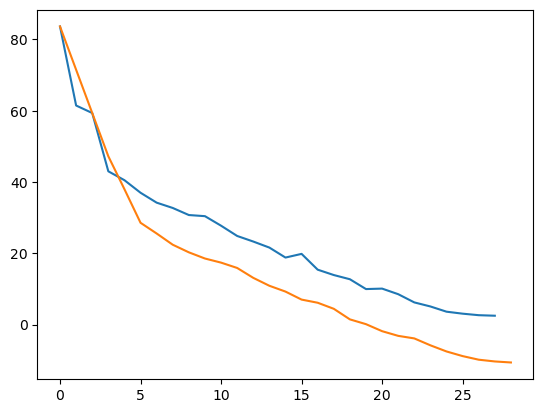

In [48]:
# find minimum from channel center
xs_mins = xs_levee_smooth.loc[3100:3300].min(axis=0)
xs_mins.index = xs_mins.index.astype(int)
# xs_mins.interpolate(method='linear').plot()
slope = xs_mins.diff().rolling(2, center=True, closed='right').mean().bfill()/2000*-1
adj_xs_mins = np.append(xs_mins[0], (xs_mins[0]-slope.cumsum()*2000))

# (xs_mins.diff()/-2000).plot()
# slope.plot()
# plt.show()
xs_mins.plot()
plt.plot(adj_xs_mins)

# Flow loss procedure
1. Allocate arrays for:  
    1. flow (n realizations, n setbacks, n segments +1)  
    2. depth (n setbacks, nrow, ncol)  
    3. water surface elevation (n setbacks, nrow, ncol)  
    4. recharge (n realizations, n setbacks, nrow, ncol)  
2. Primary iteration:  
    1. Given a cross-section with a specified width for a given setback  
    2. Calculate the depth in the channel from the flow with Manning Equation  
    3. Add depth to cross-section minimum elevation to calculate water surface elevation for the given setback and segment  
3. Secondary Iteration:  
    1. Given a segment identify which cells have a water surface elevation above ground surface (i.e., inundated)  
    2. Calculate recharge based on inundated area, hydraulic gradient due to flood depth and vertical conductivity  
    3. Sum of recharge by segment  
    4. Calculate flow leaving the segment by subtracting recharge from flow entering the segment  
4. Optional Iteration:
    1. Apply a sequence of flows that include the rising limb and falling limb in addition to the peak flow
    2. Calculate total recharge from this continuous event
5. Outermost Iteration:  
    Complete these depth, recharge, flow calculations for each subsurface realization  
    

In [14]:
from scipy.optimize import minimize_scalar

# depths = np.zeros((len(setbacks), xs_levee_smooth.shape[1]))
Q = np.zeros((100, len(setbacks), xs_levee_smooth.shape[1]+1))
Q[:,:,0] = Q_cms
# save depth arrays for each setbacks
d_arr = np.zeros((len(setbacks), nrow, ncol))
wse_arr = np.zeros((len(setbacks), nrow, ncol))
# save high recharge flows
rch_hf_arr = np.zeros((100, len(setbacks), nrow, ncol))




Rather than focusing on improving the solver iteration which isn't that bad (21 iterations isn't great but it could be worse), I should work on solution: updating roughness based on cross-section width, include levee wall roughness in wetted perimeter. Look at sensitivity of vertical conductivity. Summarize recharge by time period of flood (travel time is 13.2 hours/45 km per Whipple, about 0.3 hrs per 1 km) which is about 0.6 hrs per 2km to multiply by the recharge rate.   
The current set up with a flow minus recharge makes sense if we assume a temporary steady state is reached (true for sub half hour), but if I want to start calculating volumes for transient events then I need to account for the duration.

Whipple notes a floodplain inundation threshold of 23 m3/s at MHB where the lowest lying floodplain areas connect.

In [15]:
from time import time
# takes ~45 minutes
t=0
tic = time()
n = 0.048 # assume constant roughness for now

for t in np.arange(0,100):
    # iterate across all cross-sections
    for nseg in np.arange(0,xs_levee_smooth.shape[1]):
        # iterate across all setbacks
        for s,setback in enumerate(setbacks):
            # for a given setback imagine there is an impenetrable levee blocking overbank flow
#             xs_elevs = xs_levee_smooth.iloc[:,nseg][3100-setback:3300+setback]
            xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg], setback)
            # solve for depth that matches given flow
            if Q[t, s,nseg] >0:
                res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[t, s,nseg]), bounds=(0,10), method='bounded')
                depth = res.x
            else:
                depth = 0
            # join depth calculated at cross-section to corresponding model cells and corresponding setback
            wse_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth + xs_elevs.min()
            d_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth 
        # identify wse above surface elevation 
        d_arr = d_arr* (wse_arr > dem_data)
        # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
        # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
        rch_hf_arr[t,:,:,:] += (xs_arr==nseg)*(soil_K[t,:,:])*hf_tot[t,:,:] *(200*200)*((d_arr* + soil_thick)/soil_thick)
        Q[t, :, nseg+1] = Q[t, :, nseg] - np.nansum(rch_hf_arr[t,:, xs_arr==nseg], axis=(0))
        
toc = time()
print((toc-tic)/3600)

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered i

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))


0.7776787677738402


Text(0, 0.5, 'Flow ($m^3/s$)')

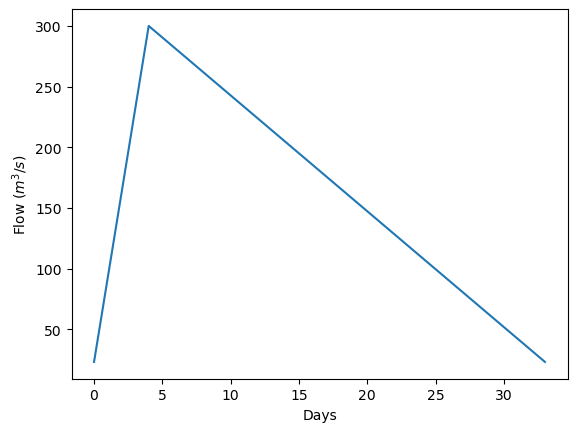

In [22]:
# for n in flood_type.index:
# 1, 2, 3 are floods long enough to apply to analysis
n=2
# typical winter baseflow, peak flow, peak location, total time (days)
# flow of 23 m3/s listed by Whipple as floodplain cutoff
q_base = 23 # 200*(0.3048**3)
q_peak = flood_type.loc[n,'cms_pk']
# total duration in days 
T = int(10**flood_type.loc[n,'log_no_d'])
p_l = flood_type.loc[n,'pk_loc']
tp = int(p_l*T)

q_rise = np.linspace(q_base, q_peak, tp)
q_fall = np.linspace(q_peak, q_base, (T-tp+1))
q_in = np.append(q_rise, q_fall[1:])
plt.plot(q_in)
plt.xlabel('Days')
plt.ylabel('Flow ($m^3/s$)')

In [23]:
from time import time
from scipy.optimize import minimize_scalar



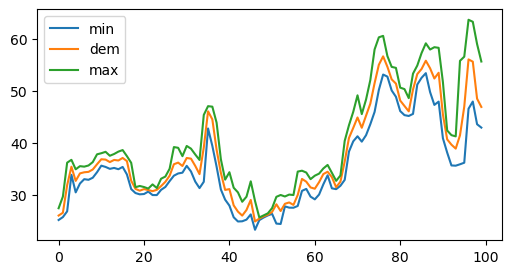

In [25]:
# find difference between water surface and cell elevations
diff = wse_arr[tp-1,-1,:] - arr_elev
diff[diff<0] = np.nan
# find the highest elevation above which there is water
bot_q = np.argmin(diff, axis=0)[rows,cols] - 1
bot_q[bot_q<0] = 0
top_q = np.argmin(diff, axis=0)[rows,cols] 
# find percentage of interim quantile
perc_q = (dem_data[rows,cols] - arr_elev[bot_q, rows,cols])/(arr_elev[top_q, rows,cols] +1E-3 - arr_elev[bot_q, rows,cols])
# percent of cell area covered by flood
perc_A = np.reshape(bot_q + perc_q, (nrow,ncol))/10

fig,ax = plt.subplots(figsize=(6,3))
n = 150
ax.plot(arr_elev[0][:,n], label='min')
ax.plot(dem_data[:,n], label='dem')
ax.plot(arr_elev[10][:,n], label='max')
ax.legend()
fig,ax=plt.subplots()
ax.imshow(perc_A)
plt.colorbar(ax.images[0], shrink=0.6)


In [26]:

def realization_recharge(t):
    # allocate arrays
    Q = np.zeros((q_in.shape[0], len(setbacks), xs_levee_smooth.shape[1]+1))
    # set inflow for segment 1 across all setbacks and for all times
    # rate of cubic meters per second
    Q[:,:,0] = np.repeat(q_in.reshape(-1,1), len(setbacks), axis=1)
    # save depth arrays for each setbacks
    d_arr = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))
    wse_arr = np.zeros((len(setbacks), nrow, ncol))
    cell_frac = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))
    # save high recharge flows
    rch_hf_arr = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))

    tic = time()
    n = 0.048 # assume constant roughness for now
    K_rch = 1.173/24 # fraction of the day that flow is on each segment for recharge
    t = 0 # tprogs realization
    #.25 hours (15 min) for 30 days run

    # iterate across streamflows
    for qn in np.arange(0, q_in.shape[0]):
        # iterate across all cross-sections
        for nseg in np.arange(0,xs_levee_smooth.shape[1]):
            # iterate across all setbacks
            for s,setback in enumerate(setbacks):
                # for a given setback imagine there is an impenetrable levee blocking overbank flow
    #             xs_elevs = xs_levee_smooth.iloc[:,nseg][3100-setback:3300+setback]
                xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg], setback)
                # solve for depth that matches given flow
                if Q[t, s,nseg] >0:
                    res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[qn, s,nseg]), 
                                          bounds=(0,10), method='bounded')
                    depth = res.x
                else:
                    depth = 0
                # join depth calculated at cross-section to corresponding model cells and corresponding setback
                wse_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth + xs_elevs.min()
                # calculate depth of water at different elevation percentiles for segment and setback
                diff = wse_arr[s,:]*(xs_arr==nseg)*(str_setbacks <= s+1) - arr_elev
                # when depth is negative remove
                diff[diff<0] = np.NaN
                # only keep cells where water level is above lowest elevation
                diffmax = np.nanmax(diff, axis=0)
                # keep cells where diffmax >0 
                x,y = np.where(diffmax>0)
                # find the highest elevation above which there is water, subtract 1 uses lower percentile
                # where the wse was below the minimum ignore
                bot_q = np.argmin(diff, axis=0)[x,y] - 1
                bot_q[bot_q<0] = 0
                top_q = np.argmin(diff, axis=0)[x,y] 
                # find percentage of interim quantile
                perc_q = (wse_arr[s, x,y] - arr_elev[bot_q, x,y])/(arr_elev[top_q, x,y] +1E-3 - arr_elev[bot_q, x,y])
                # percent of cell area covered by flood
                cell_frac[qn, s,x,y] = (bot_q + perc_q)/10
                # depth for each cell is difference between water surface and average flooded ground elevation
                d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth 

                # identify wse above surface elevation 
#             d_arr[qn,:] = d_arr[qn,:]* (wse_arr > dem_data)
            # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
            # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
            q_seep = (soil_K[t,:,:])*K_rch*hf_tot[t,:,:]*(200*200)*((d_arr[qn,:]* + soil_thick)/soil_thick)
            rch_hf_arr[qn,:,:,:] += (xs_arr==nseg) * q_seep * cell_frac[qn]
            Q[qn, :, nseg+1] = Q[qn, :, nseg] - np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))
   
    base_fn = join(data_dir, 'r'+str(t).zfill(3)+'_')
    # saving all of the flow at all steps, setbacks is needed to post-process
    Q_out = np.reshape(Q, ((q_in.shape[0]*len(setbacks), xs_levee_smooth.shape[1]+1)))
    np.savetxt(base_fn+'flow.tsv', Q_out)
    # for recharge we want to aggregate across time steps but look at differences across setbacks
    rch_out = np.reshape(rch_hf_arr.sum(axis=0), (len(setbacks)*nrow, ncol))
    np.savetxt(base_fn+'recharge.tsv', rch_out)
    toc = time()
    print((toc-tic)/3600)
    return(Q, rch_hf_arr, d_arr, cell_frac)


In [56]:
t=0
Q, rch_hf_arr, d_arr, cell_frac = realization_recharge(t)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppD

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppD

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppD

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppD

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppD

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppD

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Docu

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipy

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\U

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppD

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning: Mean of empty slice
  d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:45: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\1943237996.py:58: RuntimeWarning

0.30970749530527325


In [29]:
# d_arr[tp-1,-1,:]
xs_mins = np.full((nrow,ncol), np.nan)
for nseg in np.arange(0,xs_levee_smooth.shape[1]):
    xs_mins[xs_arr==nseg] = xs_levee_smooth.iloc[:,nseg].min()
    
wse_arr = d_arr + xs_mins
plt.imshow(xs_mins)
plt.colorbar(shrink=0.6)

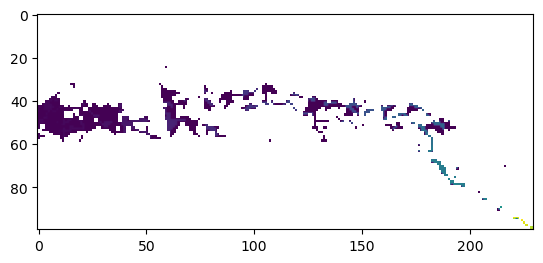

In [42]:
# mapping active cells it looks way better now, much more connected
wse_active = wse_arr*(wse_arr > arr_elev[0,:])
plt.imshow(wse_active[5,-1,:])
# plt.imshow(cell_frac[5,-1,:]>0)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_154724\230092139.py:16: RuntimeWarning: All-NaN slice encountered
  diffmax = np.nanmax(diff, axis=0)


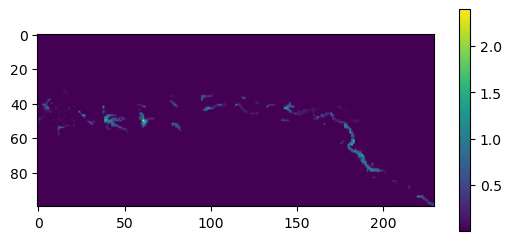

In [36]:
cell_frac = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))

qn = 5

for nseg in np.arange(0,xs_levee_smooth.shape[1]):
    # iterate across all setbacks
    for s,setback in enumerate(setbacks):
        # calculate depth of water at different elevation percentiles for segment and setback
        diff = wse_arr[qn, s,:]*(xs_arr==nseg)*(str_setbacks <= s+1) - arr_elev
        # when depth is negative remove
        diff[diff<0] = np.NaN

#         plt.imshow(np.nanmean(diff,axis=0))
#         plt.show()
        # only keep cells where water level is above lowest elevation
        diffmax = np.nanmax(diff, axis=0)
        # keep cells where diffmax >0 
        x,y = np.where(diffmax>0)
        # find the highest elevation above which there is water, subtract 1 uses lower percentile
        # where the wse was below the minimum ignore
        bot_q = np.argmin(diff, axis=0)[x,y] - 1
        bot_q[bot_q<0] = 0
        top_q = np.argmin(diff, axis=0)[x,y] 

        # diff = wse_arr[qn, s,:] - arr_elev
        # diff[diff>0] = np.NaN
        # top_q = np.argmax(diff, axis=0)[x,y] + 1
        # top_q[top_q>10] = 10

        # find percentage of interim quantile
        perc_q = (wse_arr[qn, s, x,y] - arr_elev[bot_q, x,y])/(arr_elev[top_q, x,y] +1E-3 - arr_elev[bot_q, x,y])
        # percent of cell area covered by flood
        cell_frac[qn, s,x,y] = (bot_q + perc_q)/10
        # d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth 

        # depth for each cell is difference between water surface and average flooded ground elevation
        # d_arr[qn, s,(xs_arr==nseg)&(str_setbacks <= s+1)] = np.nanmean(diff, axis=0)[(xs_arr==nseg)&(str_setbacks <= s+1)] #depth 

s = 16
# perc_q_arr = np.full((nrow,ncol),np.NaN)
# perc_q_arr[x,y] = perc_q
# plt.imshow(perc_q_arr)
plt.imshow(cell_frac[qn,s,:], vmin=1E-4)
plt.colorbar(shrink=0.6)

In [55]:
# time series
for n in [0,5, 10,15,20,25]:
    plt.plot(Q[:,-1,n])
plt.show()
# first time all segs
# longitudinal losses
for n in [0,5, 10,15,20,25]:
    plt.plot(Q[n,-1, :])
rch_hf_arr.sum(axis=(2,3))[:,-1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

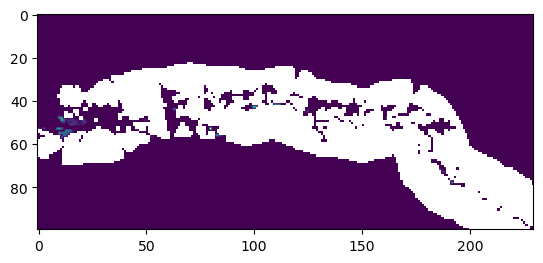

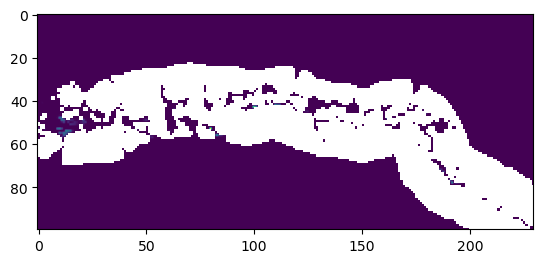

In [45]:
rch_hf_arr.shape, q_in.shape
rch_hf_arr[33,:,:,:].sum()
for n in [0, tp-1, tp-1+int((T-tp)/2)]:
#     plt.imshow(d_arr[n,-1,:])
    plt.imshow(rch_hf_arr[n,-1,:])
    plt.show()

Text(0, 0.5, 'Discharge ($m^3/s$)')

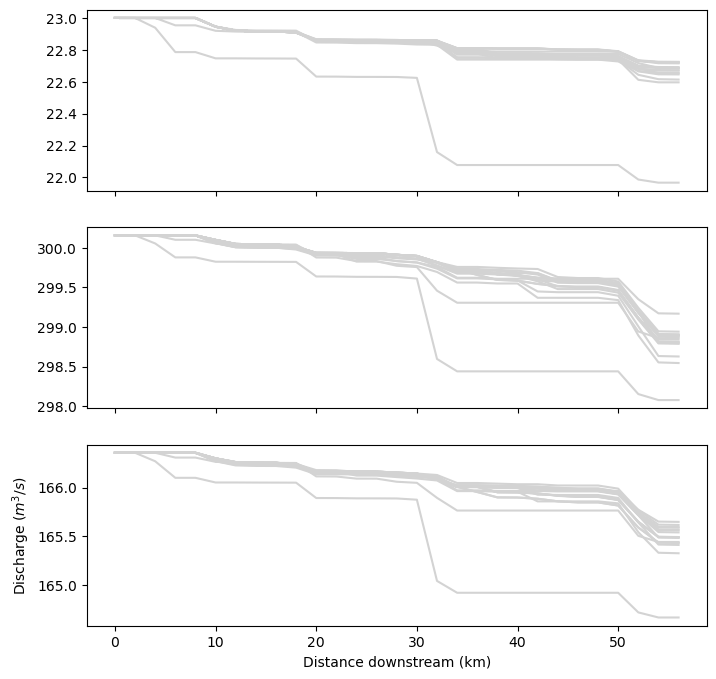

In [46]:
fig,ax = plt.subplots(3,1,figsize=(8,8), sharex=True)
# plot baseflow
Q_plt = pd.DataFrame(Q[0,:,:], index=setbacks, columns = np.arange(0,(num_segs+1)*2,2)).transpose()
Q_plt.plot(color='lightgray', legend=False, ax=ax[0])

# plot peak
Q_plt = pd.DataFrame(Q[tp-1,:,:], index=setbacks, columns = np.arange(0,(num_segs+1)*2,2)).transpose()
Q_plt.plot(color='lightgray', legend=False, ax=ax[1])

# plot midway through recession
Q_plt = pd.DataFrame(Q[tp-1+int((T-tp)/2),:,:], index=setbacks, columns = np.arange(0,(num_segs+1)*2,2)).transpose()
Q_plt.plot(color='lightgray', legend=False, ax=ax[2])

plt.xlabel('Distance downstream (km)')
plt.ylabel('Discharge ($m^3/s$)')

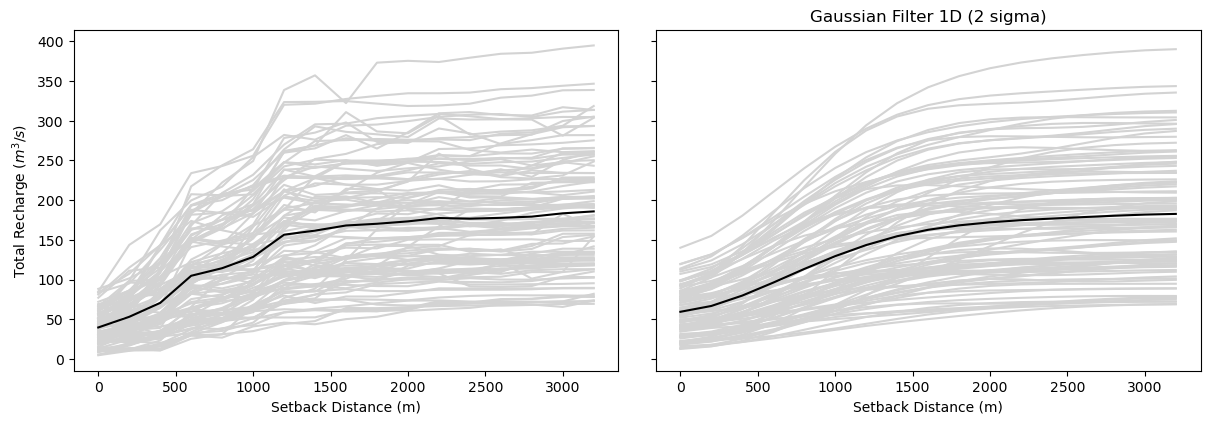

In [17]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
fig.tight_layout()
rch_xs_sum = pd.DataFrame(np.sum(rch_hf_arr, axis=(2,3)), columns= setbacks).transpose()
rch_xs_sum.plot(legend=False, color='lightgray', ax =axes[0])
rch_xs_sum.mean(axis=1).plot(color='black', ax=axes[0])


axes[0].set_xlabel('Setback Distance (m)')
axes[0].set_ylabel('Total Recharge ($m^3/s$)')

# 1d so the smoothing is specific to each realization
from scipy.ndimage import gaussian_filter1d
# smooth across setback distances so the changes in high flow area are less abrupt, makes it easier to find gradients
smooth = gaussian_filter1d(rch_xs_sum,2, axis=0)

smooth = pd.DataFrame(smooth, index= setbacks)
smooth.plot(legend=False, color='lightgray', ax=axes[1], label='Realizations')
smooth.mean(axis=1).plot(color='black', ax=axes[1], label='Mean')

axes[1].set_title('Gaussian Filter 1D (2 sigma)')

axes[1].set_xlabel('Setback Distance (m)')

# axes[1].legend()
# tranpose to fit format for gradient analysis used previously
smooth = smooth.transpose()


Text(0, 0.5, 'Realizations with a maximum gradient')

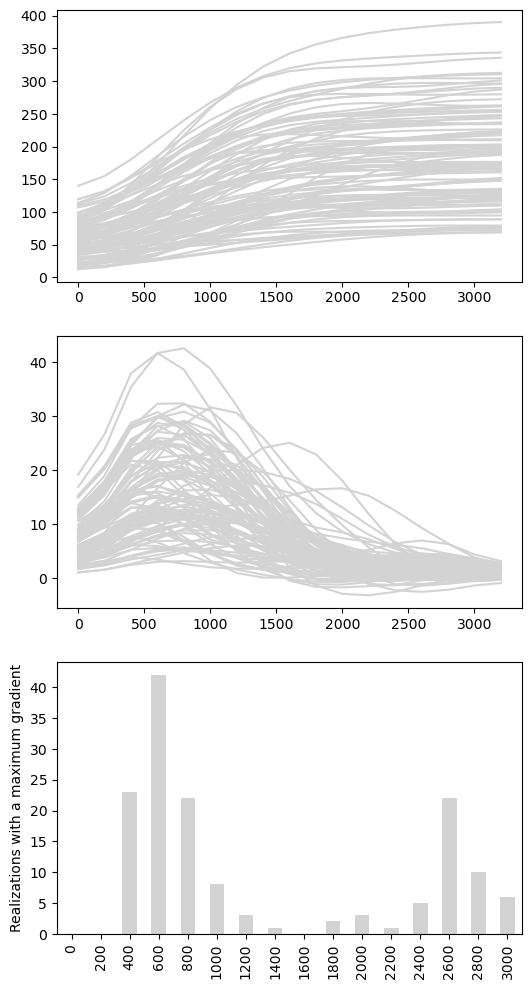

In [19]:
n='regional'
r = np.arange(0,100)
# can look at maximum of first derivative, or look where second derivative goes from + to -
grad1_df = pd.DataFrame(np.gradient(smooth)[1],  columns = setbacks)
# plt_hf_cum_area(grad1_df.loc[n].loc[r], percentile, n)

grad2_df = pd.DataFrame(np.gradient(grad1_df)[1],  columns = setbacks)
# # grad2_df
# plt_hf_cum_area(grad2_df.loc[n], percentile, n)
# find switching points
plt.show()
fig,ax=plt.subplots(3,1,figsize=(6,12), sharex=False)
smooth.loc[r].transpose().plot(legend=False,ax=ax[0], color='lightgray') #.loc[n]
plt.ylabel('High K area smoothed with setbacks')

grad1_df.loc[r].transpose().plot(legend=False,ax=ax[1], color='lightgray') #.loc[n]
plt.ylabel('First derivative of High K area')

# plt.legend(ncol=5,loc=(1.2,0.2))
# np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
max_df = pd.DataFrame(np.diff(np.sign(grad2_df)), columns = setbacks[:-1])
max_df = 1*(max_df==-2)
max_df.loc[r].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax[2], color='lightgray') #.loc[n]
plt.ylabel('Realizations with a maximum gradient')

Too much seepage loss, HK values are most likely too large, need to apply some vertical anistropy factor because I'm guessing a thin soil thickness. Initially with 2m soil thickness and standard HK field, seepage overcame streamflow. Attempting 4m with standard HK field to look at change. Fixed by applying anisotropy factor.

637.1290483200002


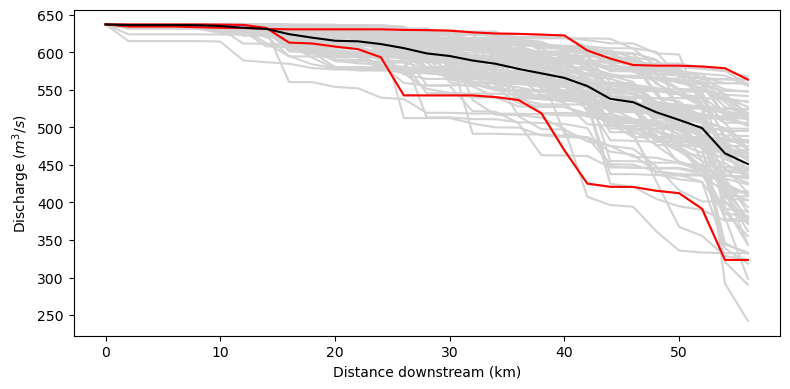

In [18]:
t=0
print(Q_cms)
fig,ax = plt.subplots(figsize=(8,4))
Q_plt = pd.DataFrame(Q[:,-1,:], columns = np.arange(0,29*2,2)).transpose()
Q_plt.plot(color='lightgray', legend=False, ax=ax)
# plot min, max
Q_plt.loc[:,Q_plt.mean(axis=0).isin(Q_plt.mean(axis=0).quantile([0, 1]).values)].plot(legend=False, color='red', ax=ax)

Q_plt.mean(axis=1).plot(color='black', label='Averaged Realizations', ax=ax)
plt.xlabel('Distance downstream (km)')
plt.ylabel('Discharge ($m^3/s$)')

fig.tight_layout()

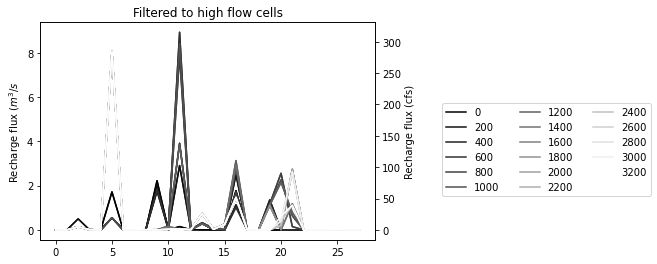

In [209]:
def plot_xs_sum(arr):
    # group recharge into upstream segments of each XS
    xs_sum = np.zeros((xs_levee_smooth.shape[1],len(setbacks)))
    for xs_n in np.arange(0,xs_levee_smooth.shape[1]):
        xs_sum[xs_n,:] = np.nansum(arr[:,xs_arr==xs_n], axis=1)
    # convert to dataframe for easier plotting
    xs_rch_df = pd.DataFrame(xs_sum,columns = setbacks)
    # plotting 
    fig, ax = plt.subplots()
    # xs_rch_df.plot(cmap='gray',  kind='bar', legend=True)
    xs_rch_df.plot(cmap='gray',  legend=False, ax=ax)
    plt.ylabel('Recharge flux ($m^3/s$')
    ax2 = ax.twinx()
    xs_rch_df.multiply((1/( 0.3048**3))).plot(cmap='gray', legend=False, ax=ax2)
    plt.ylabel('Recharge flux (cfs)')
    plt.legend(ncol=3, loc=(1.2,0.2))
    plt.xlabel('Cross section')
    plt.title('Filtered to high flow cells')
    return(xs_rch_df)
#testing
t=0
xs_rch_df0 = plot_xs_sum(rch_hf_arr[t,:])


In [25]:
# there is a consistent disagreement between recharge and the flow where recharge
# is consistently larger than recharge from Q array. I am expecting the Q array is more accurate because
# it is subtracting the recharge from each segment step by step and I think that somehow recharge is being double applied
# in it's own array
# xs_rch_df0 - np.diff(Q[0,:,:].transpose(), axis=0)

In [211]:

def arr_2_df(arr):
    ''' Take array (realizations, setbacks, nrow, ncol)'''
    # group recharge into upstream segments of each XS
    xs_sum = np.zeros((100, xs_levee_smooth.shape[1],len(setbacks)))
    for xs_n in np.arange(0,xs_levee_smooth.shape[1]):
        xs_sum[:, xs_n,:] = np.nansum(arr[:, :, xs_arr==xs_n], axis=2)
    # convert to long dataframe for seaborn plotting
    xs_sum_long = np.reshape(xs_sum, (100*xs_levee_smooth.shape[1],len(setbacks)))
    xs_sum_long = pd.DataFrame(xs_sum_long,columns = setbacks)
    xs_sum_long['r'] = np.repeat(np.arange(0,100), xs_levee_smooth.shape[1])
    xs_sum_long['nseg'] = np.tile(np.arange(0,xs_levee_smooth.shape[1]), 100)
    xs_sum_long = xs_sum_long.melt(id_vars=['r','nseg'], var_name='XS', value_name='rch_m_s')
    return(xs_sum_long)
xs_sum_long = arr_2_df(rch_hf_arr)

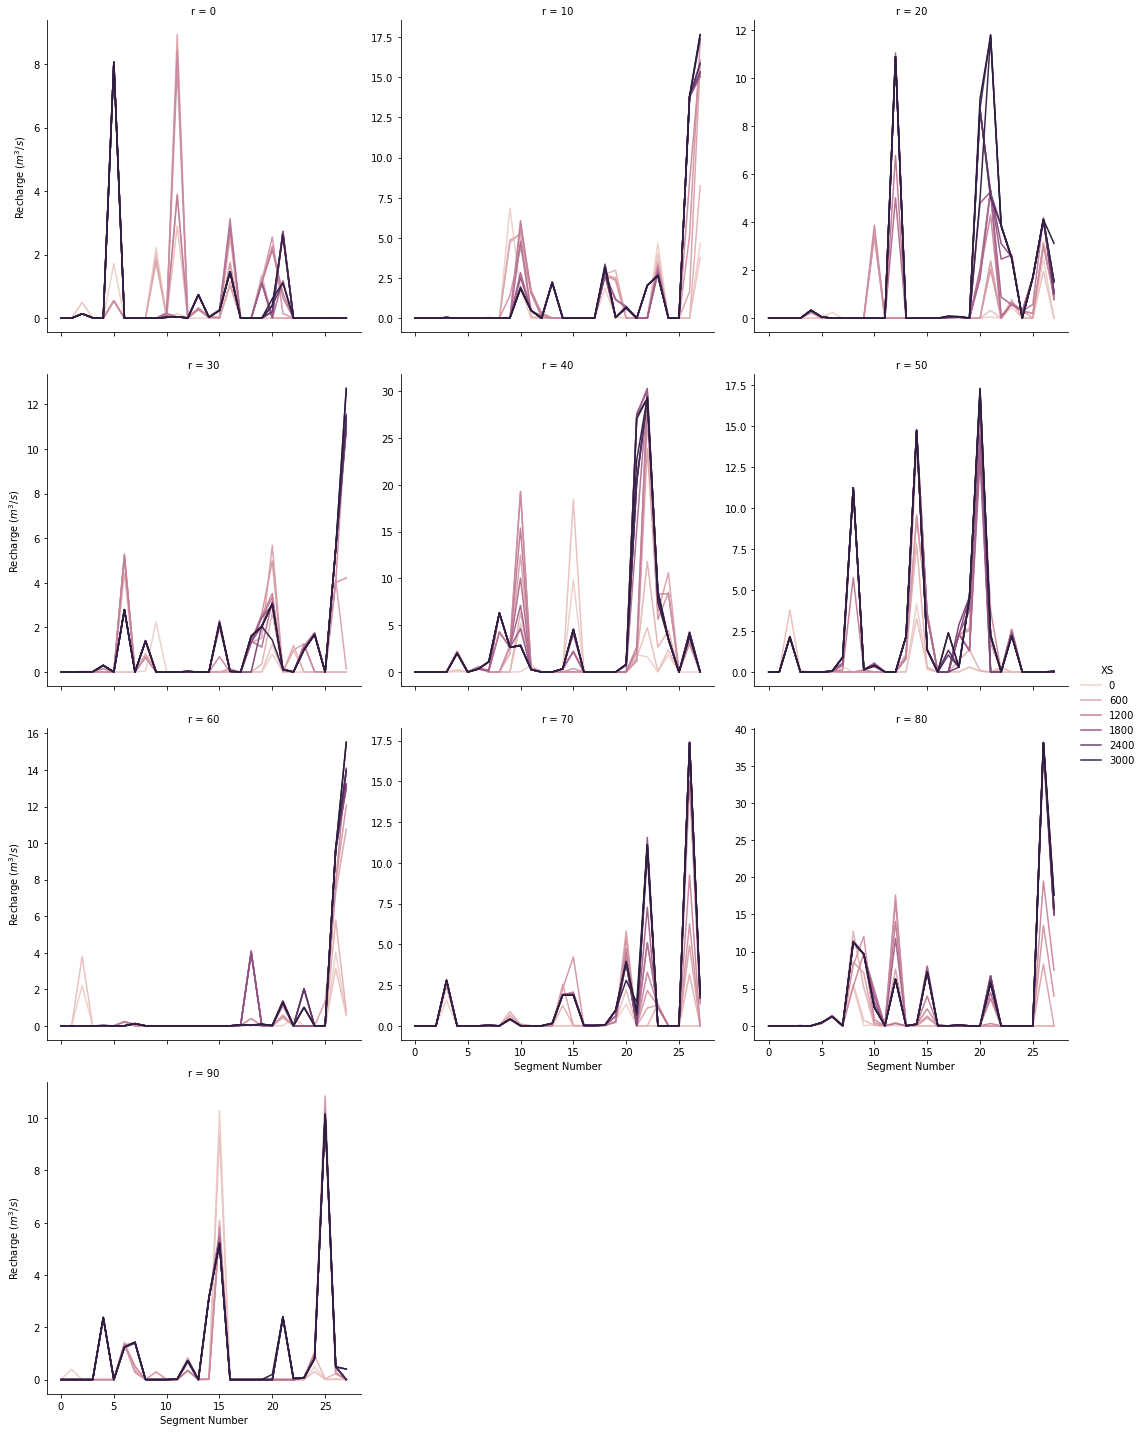

In [212]:
import seaborn as sns
# not sure why only a few colors appear in the legend
ax = sns.relplot(
    data=xs_sum_long[xs_sum_long.r.isin(np.arange(0,100,10))],
    x="nseg", y="rch_m_s",
    hue="XS", hue_order = setbacks,  col = 'r', col_wrap=3,
#     height=4, aspect=.7, 
    facet_kws={'sharey': False, 'sharex': True},
    kind="line"
)
ax.set_ylabels('Recharge ($m^3/s$)')
ax.set_xlabels('Segment Number')

## Streamflow data
Routing flow down channel: original intent was to focus on a few sizes of streamflows based on return periods (e.g., 5, 20 years) but I could run this every day with variable streamflow for the past 10 years to identify the number of days when floodplains are activated. The next level would be to run this with inundation maps for everyday.

Need to start with singular flow events to test the difficulty of running iterative flow with leakage dependent on flood depth and number of high flow cells. It's easy to think the work would be more interesting if everything was in a complex model but often the simpler more fundamental work is what is meaningful therefore I should work for parsimony by testing a singular flow and using a Darcy recharge before going more complex.

In [70]:
# Cosumnes River at Michigan Bar, daily flow cfs
# from 10/1/1983 to 10/1/2010
# inflow_15 = pd.read_csv('data\MI_bar_15min.csv', parse_dates = True, 
#                 index_col = 0, sep = ',', header = 'infer')

## Groundwater level data

## Muskingum Parameters 

K is the travel time for the river and $N_{steps}$ is the number of sub reaches so that the total travel time adds to K  
Value of X ranges from 0 for reservoir-type storage to 0.5 for a full wedge. When X = 0 there is no wedge so no backwater (e.g., level-pool reservoir). **In natural stream X is between 0 and 0.3 with a mean near 0.2.** Great accuracy is not needed due to insensitivity.  
US ACE (1990) criterion for number of routing reaches:
$$ \frac{1}{2(1-X)} \leq \frac{K}{N_{steps}\Delta t} \leq \frac{1}{2X} $$

In [261]:
N = len(xs_levee_smooth.columns)
rchlen = 2 # length of 2 km
# actual length of XS
L_XS = rchlen*N

# reaches every 1 km
L = 45 # kilomters
K = 13.2*(L_XS/L) # hourly
print('Travel time %.2f' %K ,' hours for %.1f' %L_XS,'km')

X = 0.1 # weighting between wedge and pool storage, 0 is pool, 0.5 for a full wedge
l = 1/(2*(1-X))
r = 1/(2*X)
# N = 62 # reaches of 1 km
delt = 0.5 # hours
m = K/(N*delt)

print('Reach travel time and acceptable range')
print('%.3f' %l,'<= %.3f' %m,'<= %.3f' %r)
K_rch = K/N # travel time for a reach of length total length/ number of reaches
# print('Max reach storage (ft^3/min):', Smax/K) # (ft^3/min)


Travel time 16.43  hours for 56.0 km
Reach travel time and acceptable range
0.556 <= 1.173 <= 5.000


With the given travel time for the lower Cosumnes River with 1 km length reaches requires 0.5 hourly steps and X = 0.1  
x is in the downstream longitudinal channel direction and y (stage) is in the vertical direction away from the streambed.  
Celerity equation:  
$$ c_k = \frac{dx}{dt} = \frac{dQ}{dA} = \frac{1}{B}\frac{dQ}{dy} $$

Muskingum Cunge
Variation of kinematic wave. Cunge (1969) showed when K and del t are constant it is an approximate solution of the kinematic wave. It can be considered an approxmiation of the a modified diffusion equation if 
$$ K = \frac{ \Delta X}{ c_k}  = \frac{\Delta X}{(dQ / dA )}  $$
OR $$ \Delta x = \frac{K}{c_k} $$
$$X = \frac{1}{2}(1-(\frac{Q}{B c_k S_o\Delta X)}  $$

Froude Number, V = flow velocity, surface wave speed =  sqrt(g*y), g = gravity, y= depth:
$$ Fr = \frac{V}{\sqrt{gy} }$$
$$ Fr<1.0 subcritical flow $$ $$ Fr = 1.0 critical flow $$ $$Fr> 1.0 supercritical flow $$

In [ ]:
# froude number <1 subcritical, 1 citical, >1 super critical
# V = flow velocity, surface wave speed =  sqrt(g*y), g = gravity, y= depth
# Fr = V/npsqrt(9.81*y)

Text(0, 0.5, 'Flow ($m^3/s$)')

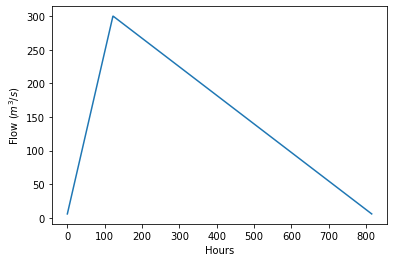

In [264]:
# for n in flood_type.index:
# 1, 2, 3 are floods long enough to apply to analysis
n=2
# typical winter baseflow, peak flow, peak location, total time (days)
q_base = 200*(0.3048**3)
q_peak = flood_type.loc[n,'cms_pk']
# total duration in days 
T = int(10**flood_type.loc[n,'log_no_d'])*24
p_l = flood_type.loc[n,'pk_loc']
tp = int(p_l*T)

q_rise = np.linspace(q_base, q_peak, tp)
q_fall = np.linspace(q_peak, q_base, (T-tp))
q_in = np.append(q_rise, q_fall)
plt.plot(q_in)
plt.xlabel('Hours')
plt.ylabel('Flow ($m^3/s$)')

In [150]:


# toc = time()
# print(np.round(toc-tic,2))
folder = '/r' + str(t).zfill(3)+'/'
folder
# np.savetxt(basedir+folder+'rch_hf_arr_cms.tsv', np.reshape(rch_hf_arr, (len(setbacks)*nrow,ncol)), delim='\t')
# np.savetxt(basedir+folder+'Q_cms.tsv', Q, delim='\t')


'r000'

In [169]:

def Adj_Muskingum(I, XS, K, X, slope, hf_tot, soil_K, soil_thick, xs_arr):
    """ 
    Given an upstream inflow route flow downstream with Muskingum and adjust for recharge losses to groundwater
    assuming losing system
    Input:
    I = Inflow at uppermost reach
    XS = XS data for all stream segments, dim = (XS distances, No. stream segments)
    K = Muskingum travel time
    X = Muskingum storage weighting (0 = none, 0.5 = reservoir)
    soil_K = streambed hydraulic conductivity, dim = (NROW, NCOL)
    soil_thick = streambed thickness, dim = (NROW, NCOL)
    xs_arr = relates array location to stream segment, dim = (NROW,NCOL)
    
    Output:
    Q = discharge for each segment
    S = storage for each segment
    mb = mass balance error
    e = excess storage removed from channel
    swe = surface water elevation
    dh = hydraulic gradient between stream and groundwater
    qA = groundwater seepage from each segment
    rch_arr = array of groundwater recharge for model domain, dim = (NROW, NCOL, time)
    d_arr = array of flood depth for model domain, dim = (NROW, NCOL, time)
    """
    T = len(I)
    N = XS.shape[1]
    # N rows and T columns
    dim = [N+1, T]
    dim2 = [N, T]
    Q = np.zeros(dim)
    S = np.zeros(dim2)
    mb = np.zeros(dim2)
    e = np.zeros(dim2)
    swe = np.zeros(dim2)
    dh = np.zeros(dim2)
    qA = np.zeros(dim2)
    rch_arr = np.zeros((nrow, ncol, T))
    d_arr = np.zeros((nrow, ncol, T))
    wse_arr = np.zeros((nrow, ncol, T))

    Q[0,:] = I # set first row as historic inflow
    Q[1:,0] = Q[0,0] # assume initial inflow equals outflow all reaches
    S[:,0] = K*Q[1,0] # assume initial storage equals outflow because no wedge storage
    
    # Muskingum coefficients
    C1 = (delt - 2*K*X)/(2*K*(1-X)+delt)
    C2 = (delt + 2*K*X)/(2*K*(1-X)+delt)
    C3 = (2*K*(1-X)-delt)/(2*K*(1-X)+delt)
#     print('C1:', C1,'C2:', C2, 'C3:', C3)
    
    for j in range(0,T-1):
        for i in np.arange(0, N):
#         # solve for depth that matches given flow
            if Q[i,j] >0:
                d0 = [d_arr[(xs_arr==i), j-1].max()]
            # flow needs to be in cubic meters per second not hour for Manning
                res = minimize_scalar(min_Q, args = (XS.iloc[:,i], n, slope.iloc[i], Q[i, j]/(60*60)), 
                                      bounds=(0.1,10), method='bounded', tol=1E-3) 
                depth = res.x #[0]
            else:
                depth = 0
    #         # join depth calculated at cross-section to corresponding model cells and corresponding setback
            wse_arr[(xs_arr==i), j] = depth + XS.iloc[:,i].min()
            d_arr[(xs_arr==i), j] = depth 
            # identify wse above surface elevation 
            d_arr[(xs_arr==i), j] = d_arr[(xs_arr==i), j] * (wse_arr[(xs_arr==i), j] > dem_data[(xs_arr==i)])
            # update to allow for gw disconnection
    #         dh[:, j] =  (swe[:,j] - gwe)/(elev - gwe)
            # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
            # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
            # need to convert HK from m/s to m/h
            rch_arr[:,:, j] += (xs_arr==i)*(soil_K*(60*60))*hf_tot *(200*200)*((d_arr[:,:,j] * + soil_thick)/soil_thick)
#             Q[i+1,j ] = Q[i, j] - np.nansum(rch_arr[xs_arr==i, j], axis=(1,2))
            # groundwater seepage term
#             q = k[i]*dh[i,j]*perimeter_base*rchlen # darcian groundwater flow
            qA[i,j] = np.nansum(rch_arr[xs_arr==i, j], axis=(0)) 
            # calculate flow into next segment
            Q[i+1,j+1] = np.clip(C1*Q[i,j+1] + C2*Q[i,j] + C3*Q[i+1,j] - qA[i,j], 0, 1E15)
            # calculate storage in stream channel
            S[i,j+1] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j]))
            
#         if current storage is greater than max
#             if S[i,j] > Smax:
#                 # calculate the excess storage
#                 e[i,j] = S[i,j] - Smax
#                 # remove the excess storage from the outflow because it
#                 # is considered overbank flow
#                 Q[i,j] = Q[i,j] - e[i,j]/(K*(1-X))
#                 # reduce storage by amount that went overbank
#                 S[i,j] = S[i,j] - e[i,j]
                
            # mass balance check
            mb[i,j] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j])) - S[i,j+1]
#         swe[:, j+1] = np.linspace(TWC_stage(Q[i+1,j+1]), MB_stage(Q[i+1,j+1]), 48)
#         dh[:, j+1] =  swe[:,j+1] - gwe[:,j+1]
    return(Q, S, rch_arr, d_arr, qA, mb)

In [200]:
# i=0
# setback=200
# # xs_elevs.iloc[:,9].plot()
# xs_levee_smooth.loc[3100-setback:3300+setback,:].iloc[:,1].plot()

In [170]:
# I = inflow_15_reg.Discharge_cfs.values
# need to convert to cfm from cfs
# I0 = I*60
# need to convert from cms to cmh
Q0= q_in*60*60

r=0
setback = 0
n = 0.048 # assume constant roughness for now

# takes 23 minutes to run about 1E3 time steps for 1 realization
t1 = datetime.now()
xs_elevs = xs_levee_smooth.loc[3100-setback:3300+setback,:]

tQ, tS, rch_arr, d_arr, qA, mb = Adj_Muskingum(Q0, xs_elevs, K_rch, X, slope, hf_tot[r,:,:], soil_K[r,:,:], soil_thick, xs_arr)
t2 =  datetime.now()
print(t2-t1)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\scipy\optimize\_minimize.py:784: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))


0:22:22.933594


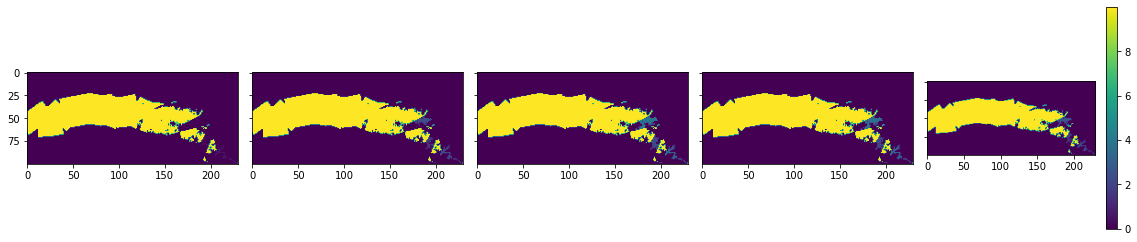

In [201]:

stps= [0, 60, 150, 250, 600]
fig,ax = plt.subplots(1,len(stps), sharex=True, sharey=True, figsize=(16,8))
for n, i in enumerate(stps):
#     im = ax[n].imshow(rch_arr[:,:,i])
    im = ax[n].imshow(d_arr[:,:,i])
fig.tight_layout()
fig.colorbar(im, shrink=0.4)

Travel time out 15.00 hours per km


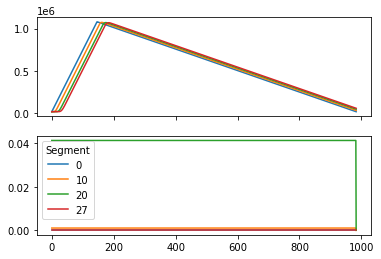

In [175]:
# the floodwave is moving too slowly
# it says it is traveling 10*2000 m in 600*0.5 hours
# and it should be about
print('Travel time out %.2f'%((600*0.5)/(10*2)), 'hours per km')
fig,ax = plt.subplots(2,1, sharex=True)
for i in [0,10,20,27]:
    ax[0].plot(tQ[i,:], label = str(i))
    ax[1].plot(qA[i,:], label = str(i))

plt.legend(title='Segment')
# plt.xlim([120,250])

Text(0, 0.5, 'Celerity')

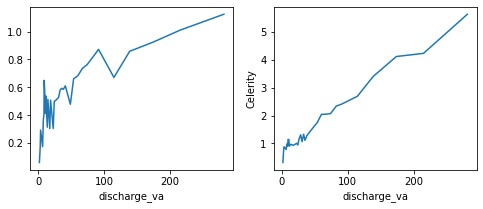

In [76]:
sfr_dir = gwfm_dir+'/SFR_data/'
# discharge is m3/day
mb = pd.read_csv(sfr_dir+ 'michigan_bar_icalc4_data.csv')
mb.discharge_va /= 86400

mb_diff = mb.diff(axis=0)
mb['ck'] = mb_diff.discharge_va/(mb_diff.gage_height_va * mb.chan_width )
mb['delX'] = K/mb.ck
mb['Fr'] = mb.discharge_va/(mb.gage_height_va *mb.chan_width)/ np.sqrt(mb_diff.gage_height_va * 9.80665 )

fig,axes=plt.subplots(1,2, figsize=(8,3))
mb.plot(x = 'discharge_va',y='Fr', label='Fr',legend=False, ax=axes[0])
ax.set_ylabel('Froude Number')
mb.plot(x = 'discharge_va',y='ck',  label='ck',legend=False, ax=axes[1])
axes[1].set_ylabel('Celerity')


In [119]:
def Muskingum(I, N, K, X):
    T = len(I)
    # N rows and T columns
    dim = [N+1, T]
    dim2 = [N, T]
    Q = np.zeros(dim)
    S = np.zeros(dim2)
    mb = np.zeros(dim2)
    e = np.zeros(dim2)
    
    Q[0,:] = I # set first row as historic inflow
    Q[1:,0] = Q[0,0] # assume initial inflow equals outflow all reaches
    S[:,0] = K*Q[1,0] # assume initial storage equals outflow because no wedge storage
    
    # Muskingum coefficients
    C1 = (delt - 2*K*X)/(2*K*(1-X)+delt)
    C2 = (delt + 2*K*X)/(2*K*(1-X)+delt)
    C3 = (2*K*(1-X)-delt)/(2*K*(1-X)+delt)
#     print('C1:', C1,'C2:', C2, 'C3:', C3)
    
    for j in range(0,T-1):
        for i in np.arange(0, N):
            Q[i+1,j+1] = np.clip(C1*Q[i,j+1] + C2*Q[i,j] + C3*Q[i+1,j], 0, 1E15)
            
    return(Q)

## Muskingum Routing

## Distance and then time calculations

In [184]:
def Adj_Muskingum(I, N, K, X, k, gwe, elev):
    """ 
    Given an upstream inflow route flow downstream with Muskingum and adjust for recharge losses to groundwater
    assuming losing system
    Input:
    I = Inflow at uppermost reach
    N = number of segments
    K = Muskingum travel time
    X = Muskingum storage weighting (0 = none, 0.5 = reservoir)
    k = streambed hydraulic conductivity
    gwe = groundwater elevation
    elev = elevation of stream top for seepage calculation
    """
    T = len(I)
    # N rows and T columns
    dim = [N+1, T]
    dim2 = [N, T]
    Q = np.zeros(dim)
    S = np.zeros(dim2)
    mb = np.zeros(dim2)
    e = np.zeros(dim2)
    swe = np.zeros(dim2)
    dh = np.zeros(dim2)
    qA = np.zeros(dim2)
    
    Q[0,:] = I # set first row as historic inflow
    Q[1:,0] = Q[0,0] # assume initial inflow equals outflow all reaches
    S[:,0] = K*Q[1,0] # assume initial storage equals outflow because no wedge storage
    
    # Muskingum coefficients
    C1 = (delt - 2*K*X)/(2*K*(1-X)+delt)
    C2 = (delt + 2*K*X)/(2*K*(1-X)+delt)
    C3 = (2*K*(1-X)-delt)/(2*K*(1-X)+delt)
#     print('C1:', C1,'C2:', C2, 'C3:', C3)
    
    for j in range(0,T-1):
        # replace linear interpolation with Manning equation with XS data
        swe[:, j] = np.linspace(TWC_stage(Q[-1,j]), MB_stage(Q[0,j]), 48)+elev
        # update to allow for gw disconnection
        dh[:, j] =  (swe[:,j] - gwe)/(elev - gwe)
        for i in np.arange(0, N):
            # groundwater seepage term
            q = k[i]*dh[i,j] # darcian groundwater flow
            qA[i,j] = q*perimeter_base*rchlen # volumetric groundwater seepage
            Q[i+1,j+1] = np.clip(C1*Q[i,j+1] + C2*Q[i,j] + C3*Q[i+1,j] - qA[i,j], 0, 1E15)
            
            S[i,j+1] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j]))
            
#         if current storage is greater than max
#             if S[i,j] > Smax:
#                 # calculate the excess storage
#                 e[i,j] = S[i,j] - Smax
#                 # remove the excess storage from the outflow because it
#                 # is considered overbank flow
#                 Q[i,j] = Q[i,j] - e[i,j]/(K*(1-X))
#                 # reduce storage by amount that went overbank
#                 S[i,j] = S[i,j] - e[i,j]
                
            # mass balance check
            mb[i,j] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j])) - S[i,j+1]
#         swe[:, j+1] = np.linspace(TWC_stage(Q[i+1,j+1]), MB_stage(Q[i+1,j+1]), 48)
#         dh[:, j+1] =  swe[:,j+1] - gwe[:,j+1]
    return(Q, S, e, mb)

In [185]:
# Flow statistics 
def stat(x):
    print('Min:', np.min(x), 'Max:', np.max(x), 'Mean:', np.mean(x))

# 15 minute discharge

In [186]:
# Run of adjusted Muskingum routing which gives outflow for all reaches

I = inflow_15_reg.Discharge_cfs.values
# need to convert to cfm from cfs
I0 = I*60

t1 = datetime.now()
tQ, tS, e, mb = Adj_Muskingum(I0, N, K, X, krch, gwe, elev)
t2 =  datetime.now()
print(t2-t1)



0:07:27.300214


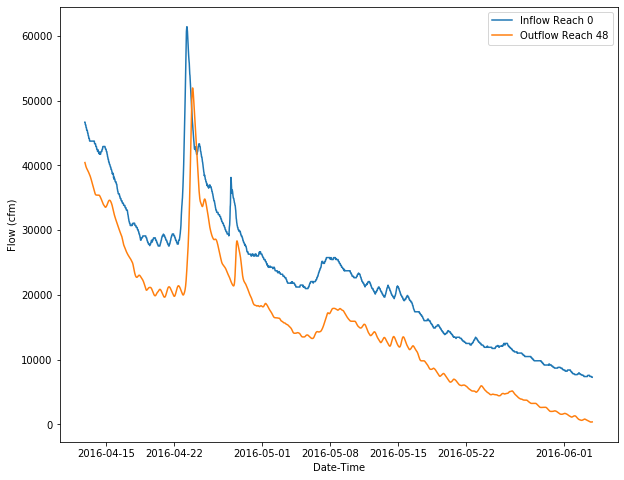

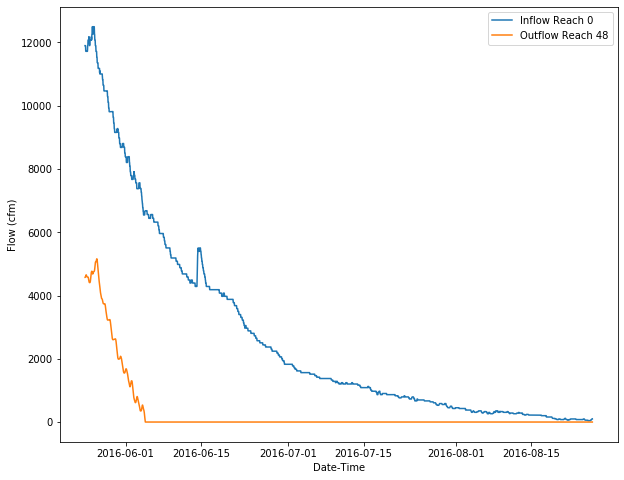

In [187]:
r = 47 # between 0 and 47
# between 0 and 200,000
outflow = pd.DataFrame(index = inflow_15_reg.index, data = np.transpose(tQ))
dt = np.arange(194000,199000)
plt.figure(figsize = (10,8))
plt.plot(outflow[1][dt])
plt.plot(outflow[48][dt])
plt.xlabel('Date-Time')
plt.ylabel('Flow (cfm)')
plt.legend(['Inflow Reach 0', 'Outflow Reach 48'])
plt.savefig('Routed_inflow_outflow_peaks', dpi = 300, bbox = 8)
